<a href="https://colab.research.google.com/github/Adhyatik/MLM-PROJECT-REPORT/blob/main/311063_FAAD_Individual_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load the Dataset:

We load the stock price data (df) from a CSV file. The dataset.
We only use the 'Close' prices for anomaly detection.

<ipython-input-11-3b8813f65fa0>:14: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


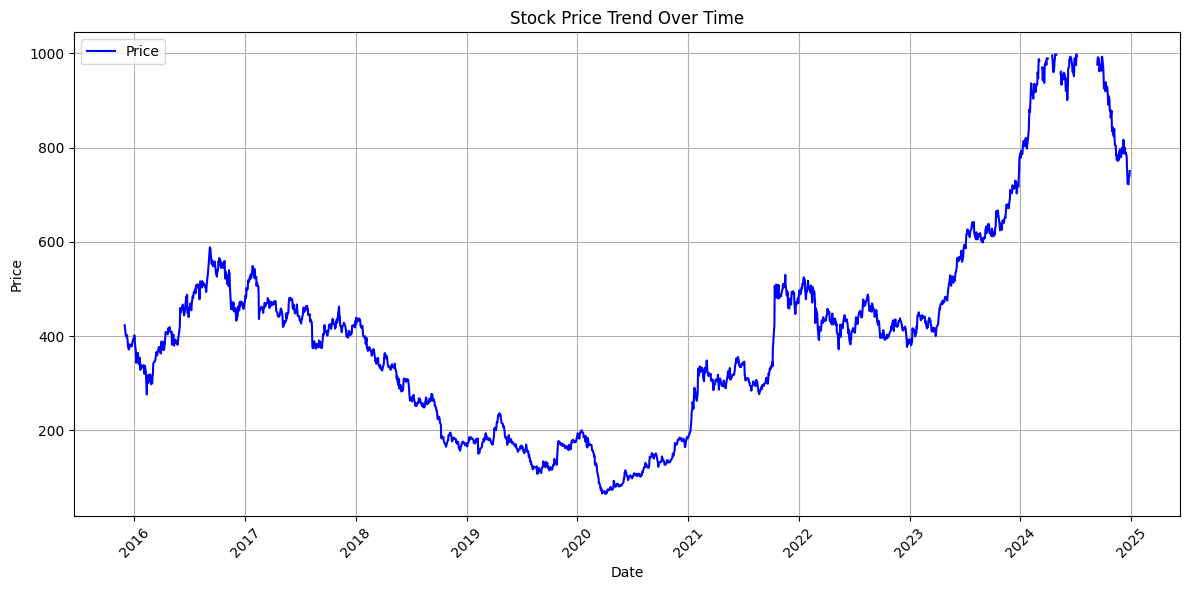

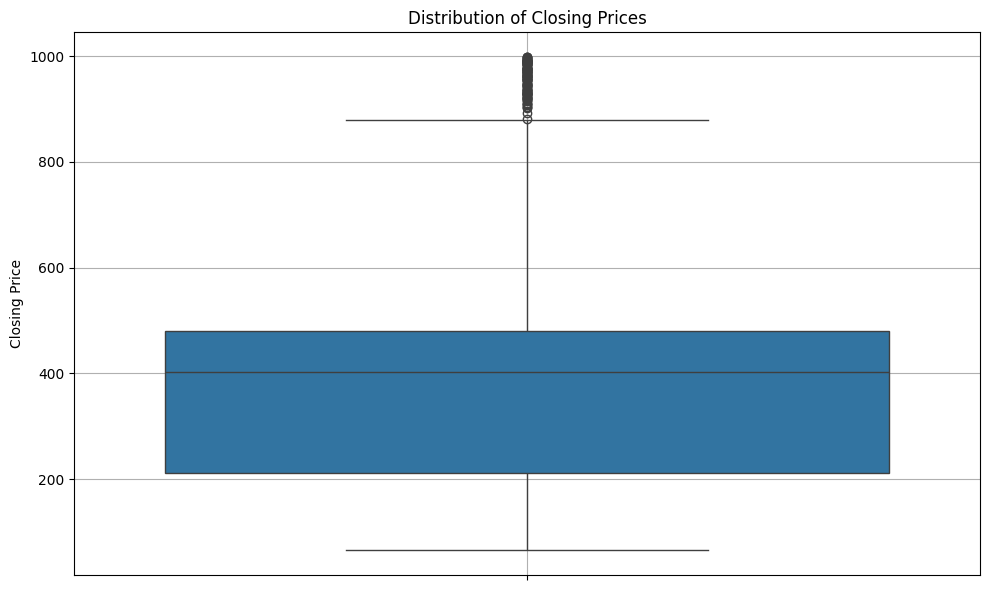

<ipython-input-11-3b8813f65fa0>:44: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['Price'], shade=True)


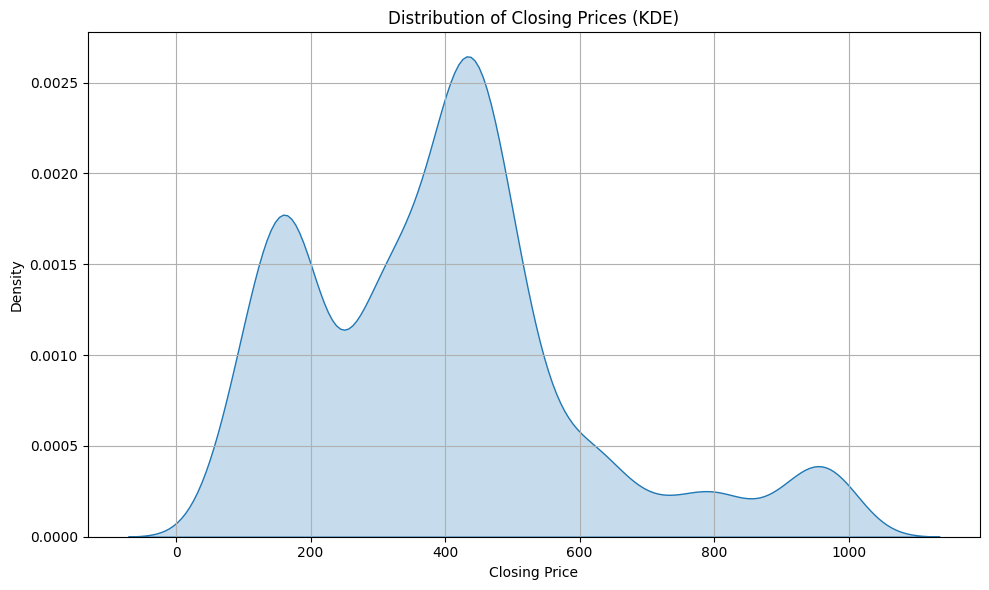

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras

# Load the Dataset
df = pd.read_csv('/content/TAMO Historical Data (4).csv')

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Ensure 'Price' column is of numeric type
df['Price'] = pd.to_numeric(df['Price'], errors='coerce') # Convert to numeric, handle errors

# EDA - Visualizations
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Price', color='blue')

plt.title("Stock Price Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution of closing prices using a boxplot for better visualization
plt.figure(figsize=(10, 6))
sns.boxplot(y=df['Price']) # Use seaborn boxplot
plt.title("Distribution of Closing Prices")
plt.ylabel("Closing Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of closing prices using a KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Price'], shade=True)
plt.title("Distribution of Closing Prices (KDE)")
plt.xlabel("Closing Price")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

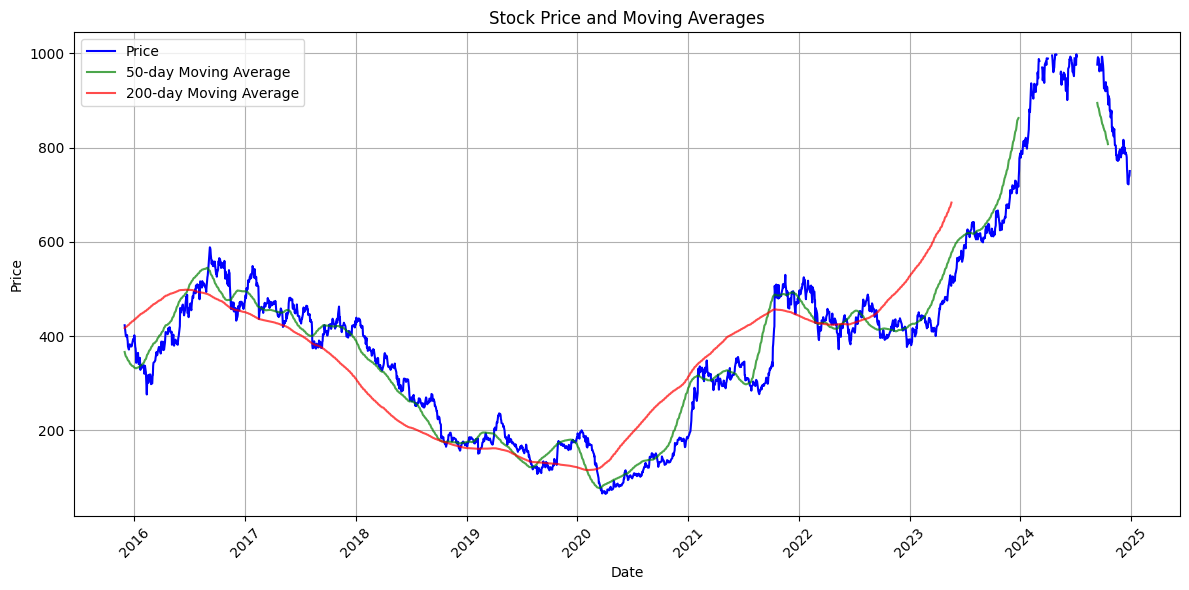

In [12]:
# Moving Average (e.g., 50-day and 200-day)
df['50-day MA'] = df['Price'].rolling(window=50).mean()
df['200-day MA'] = df['Price'].rolling(window=200).mean()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Price', color='blue')
plt.plot(df.index, df['50-day MA'], label='50-day Moving Average', color='green', alpha=0.7)
plt.plot(df.index, df['200-day MA'], label='200-day Moving Average', color='red', alpha=0.7)
plt.title("Stock Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-13-e39954e19a81>:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Daily Return'] = df['Price'].pct_change()


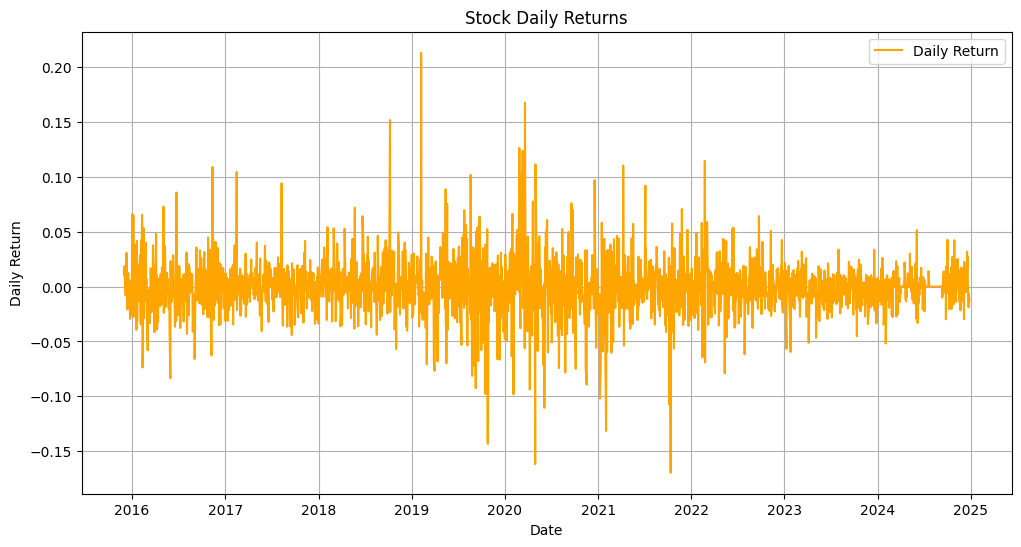

In [13]:
# Daily Returns (percentage change)
df['Daily Return'] = df['Price'].pct_change()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Daily Return'], label='Daily Return', color='orange')
plt.title("Stock Daily Returns")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Checking for missing values
missing_data = df.isnull().sum()
print("Missing Data Count:\n", missing_data)

Missing Data Count:
 Price            65
Open              0
High              0
Low               0
Vol.              1
Change %          0
50-day MA       225
200-day MA      400
Daily Return      1
dtype: int64


We normalize the 'Price' column using MinMaxScaler to scale the values between 0 and 1.

In [15]:
# We will use 'Price' for anomaly detection
scaled_data = df[['Price']]
# Normalize the 'Price' column to scale the values to range [0, 1]
scaler = MinMaxScaler()
scaled_data['Price'] = scaler.fit_transform(scaled_data[['Price']])

<ipython-input-15-1d19b70cdbe2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data['Price'] = scaler.fit_transform(scaled_data[['Price']])


This function creates sequences of data for the model.
It loops through the dataset and creates sequences of length time_steps for X (input) and assigns the corresponding value of y (target) at the time_steps index.

In [16]:
# Step 4: Create sequences of data for training and testing
TIME_STEPS = 30
def create_sequences(X, time_steps=TIME_STEPS):
    Xs = []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])  # Create sequences from the data
    return np.array(Xs)
# Create sequences for training and testing
X = create_sequences(scaled_data['Price'].values)  # Use 'Price' column values
x_train, x_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]
print(f"Training data shape: {x_train.shape}")
print(f"Testing data shape: {x_test.shape}")

Training data shape: (1775, 30)
Testing data shape: (444, 30)


Built the AutoEncoder model with an encoder-decoder architecture.

In [17]:
#step 5: Build the AutoEncoder model


model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(x_train.shape[1], 1)),
    keras.layers.RepeatVector(x_train.shape[1]),
    keras.layers.LSTM(64, activation='relu', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Trained the model and calculated reconstruction loss.

Epoch 1/20


<ipython-input-22-2c15273b68d2>:14: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])
<ipython-input-22-2c15273b68d2>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(method='ffill', inplace=True)
<ipython-input-22-2c15273b68d2>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() in

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 368ms/step - loss: 0.2043 - val_loss: 0.1644
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.1913 - val_loss: 0.1576
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - loss: 0.1844 - val_loss: 0.1503
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 235ms/step - loss: 0.1860 - val_loss: 0.1429
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - loss: 0.1643 - val_loss: 0.1352
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.1639 - val_loss: 0.1269
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.1534 - val_loss: 0.1174
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - loss: 0.1409 - val_loss: 0.1068
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.1243 - val_loss: 0.0949
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.1160 - val_loss: 0.0808
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - loss: 0.1006 - val_loss: 0.0647
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step - loss: 0.0786 - val_loss: 0.0472


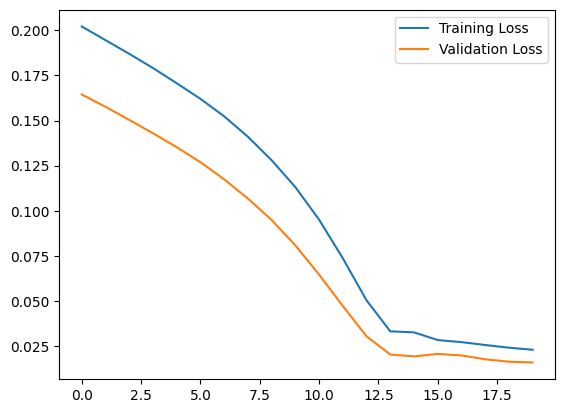

In [22]:
# Step 6: Train the model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import keras

# Load the Dataset
df = pd.read_csv('/content/TAMO Historical Data (4).csv')

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

# Ensure 'Price' column is of numeric type and handle potential errors
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# Fill NaN values in 'Price' using forward fill
df['Price'].fillna(method='ffill', inplace=True)

# ... (rest of your code) ...

# Normalize the 'Price' column
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price']])


# ... (rest of your code) ...

# Create sequences
TIME_STEPS = 30
def create_sequences(X, time_steps=TIME_STEPS):
    Xs = []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

X = create_sequences(scaled_data)
x_train, x_test = X[:int(0.8 * len(X))], X[int(0.8 * len(X)):]

# Reshape data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


# Build the model
model = keras.Sequential([
    keras.layers.LSTM(64, activation='relu', input_shape=(x_train.shape[1], 1)),
    keras.layers.RepeatVector(x_train.shape[1]),
    keras.layers.LSTM(64, activation='relu', return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
])

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mse')


# Train the model
history = model.fit(x_train, x_train, epochs=20, batch_size=256, validation_data=(x_test, x_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [23]:
# Step 7: Function to calculate reconstruction loss
def calculate_reconstruction_loss(data, model):
    reconstructions = model.predict(data)
    # Reshape the reconstructions to match the original input shape
    reconstructions = reconstructions.reshape(data.shape)
    # Calculate reconstruction error
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

Set a threshold to detect anomalies (95th percentile of the reconstruction loss).

In [24]:
# Evaluate the model on the test data
X_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
reconstruction_loss_test = calculate_reconstruction_loss(X_test, model)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step


Identified anomalies based on reconstruction errors exceeding the threshold and calculated the percentage of anomalies detected.

In [25]:
# Step 8: Set a threshold to detect anomalies (90th percentile)
# Step 9: Identify anomalies based on reconstruction error exceeding the threshold

threshold = np.percentile(reconstruction_loss_test, 95)
anomalies = reconstruction_loss_test > threshold
anomalous_percentage = np.mean(anomalies) * 100
print(f"Percentage of anomalies detected: {anomalous_percentage:.2f}%")

Percentage of anomalies detected: 5.18%


In [26]:
# Display results
print(f"Number of anomalies detected in test data: {np.sum(anomalies)}")

Number of anomalies detected in test data: 23


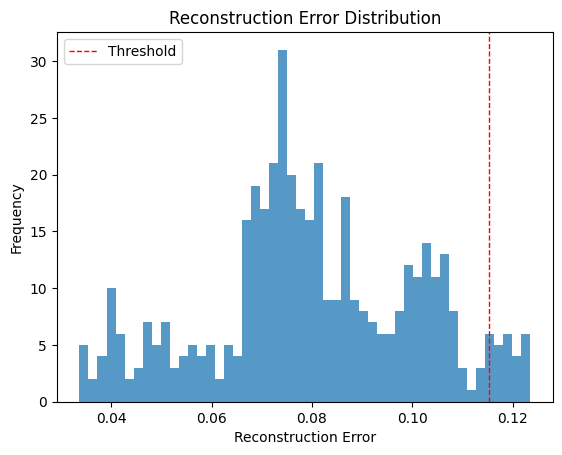

Indices of anomalies: [176 177 178 179 180 181 182 261 262 263 264 265 266 267 268 269 270 271
 272 273 274 276 277]


In [27]:
# Visualize reconstruction error
plt.hist(reconstruction_loss_test, bins=50, alpha=0.75)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=1, label='Threshold')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Mark anomalies in the dataset
anomaly_indices = np.where(anomalies)[0]
print(f"Indices of anomalies: {anomaly_indices}")

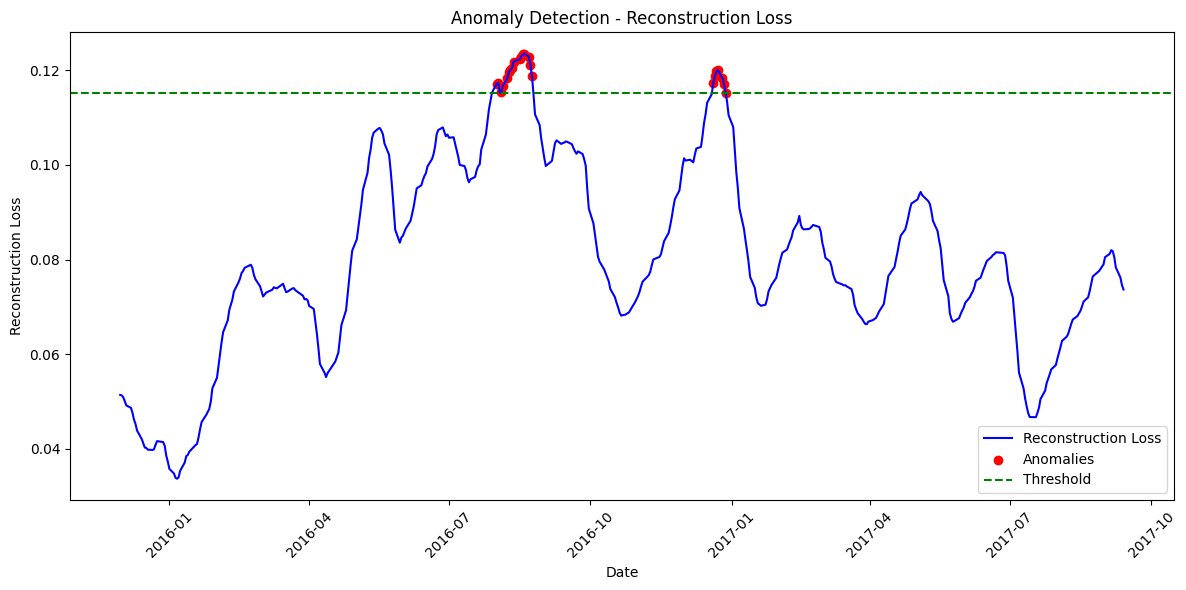

In [30]:
# ... (Your existing code)

# Plotting
plt.figure(figsize=(12, 6))

# Extract dates for plotting
test_dates = df.index[len(df) - len(reconstruction_loss_test):]

# Plot reconstruction loss
plt.plot(test_dates, reconstruction_loss_test, color='blue', label='Reconstruction Loss')

# Highlight anomalies
# Ensure anomalies is 1-dimensional for indexing
anomalies_1d = anomalies.flatten()
plt.scatter(test_dates[anomalies_1d], reconstruction_loss_test[anomalies_1d], color='red', label='Anomalies')

# Add threshold line
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')

# Labels, title, legend, and rotated x-axis labels
plt.title('Anomaly Detection - Reconstruction Loss')
plt.xlabel('Date')
plt.ylabel('Reconstruction Loss')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

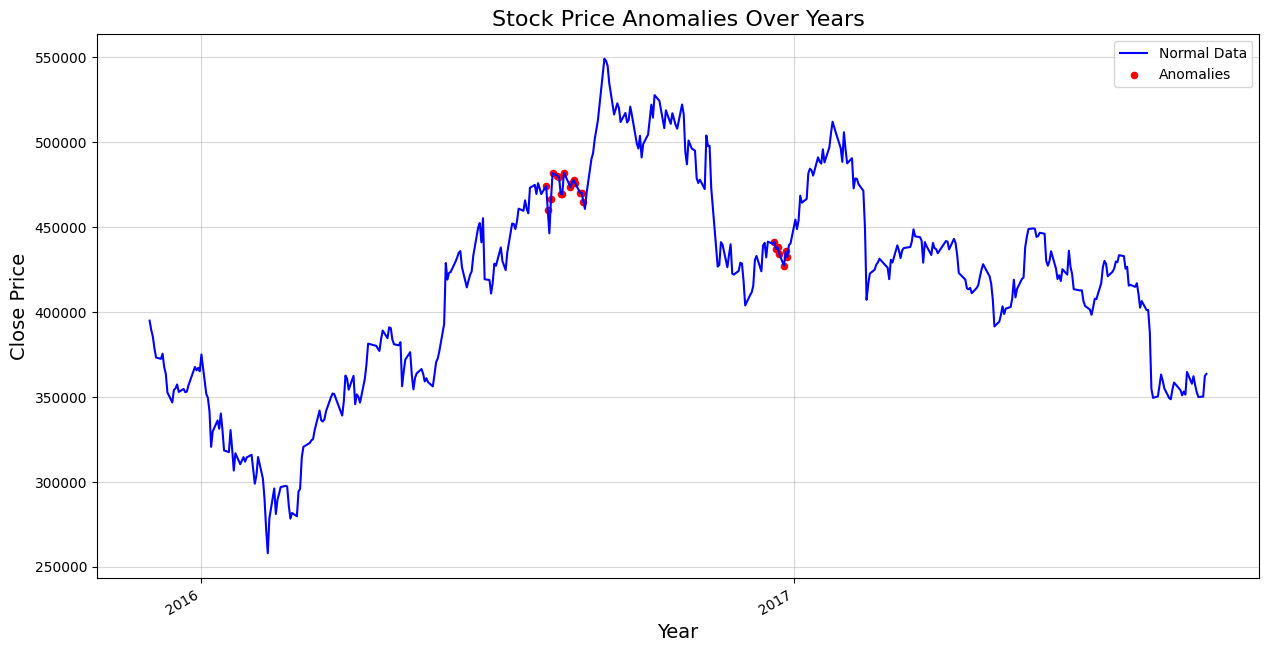

In [32]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 1: Map anomalies back to the original Close prices
original_prices = scaler.inverse_transform(df[['Price']].iloc[len(df) - len(reconstruction_loss_test):])

# Identify normal and anomalous prices
# Accessing the first element of anomalies array to ensure it's 1-dimensional
normal_prices = original_prices[~anomalies[:, 0]]
anomalous_prices = original_prices[anomalies[:, 0]]

# Get corresponding dates for normal and anomalous data
# Accessing the first element of anomalies array to ensure it's 1-dimensional
normal_dates = df.index[len(df) - len(reconstruction_loss_test):][~anomalies[:, 0]]
anomalous_dates = df.index[len(df) - len(reconstruction_loss_test):][anomalies[:, 0]]

# Step 2: Plot the data
plt.figure(figsize=(15, 8))
plt.plot(df.index[len(df) - len(reconstruction_loss_test):], original_prices, color='blue', label='Normal Data')
plt.scatter(anomalous_dates, anomalous_prices, color='red', label='Anomalies', s=20)

# Formatting the x-axis to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gcf().autofmt_xdate()

plt.title('Stock Price Anomalies Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Close Price', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.show()